# Noise model selection on NANOGrav pulsars

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import glob, os, json, string, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging, inspect, copy
logging.basicConfig(level=logging.WARNING)

In [3]:
import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions import models, model_utils, blocks
from enterprise_extensions.models import model_singlepsr_noise
from enterprise_extensions.chromatic import solar_wind, chromatic
from enterprise_extensions.hypermodel import HyperModel

# Red-noise model selection on 12.5yr Dataset

## Get par, tim, and noise files

In [4]:
# psr = Pulsar('./partim_no_noise/J0613-0200_NANOGrav_11yv0.gls.strip.par',
#              './partim_no_noise/J0613-0200_NANOGrav_11yv0.tim',
#               ephem='DE436')

In [5]:
# noisefiles = sorted(glob.glob('../11yr_stochastic_analysis/nano11y_data/noisefiles/*.json'))

In [6]:
# params = {}
# for noisefil in noisefiles:
#     with open(noisefil, 'r') as fp:
#         params.update(json.load(fp))

## Load Pickle File 

In [7]:
psrname = 'J0030+0451'#'J1911+1347'
filepath = './no_dmx_pickles/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

## Setup model

__Very Import:__ What follows is an __example__ of noise model selection. For *most* pulsars the choice of noise models used in any given model selection analysis will be different than the ones chosen here. Those working on pulsars highlighted in the 11-year noise model analysis should include those models in their analyses and also use the best combination of models from that work in any final model selection that is done.

In [8]:
# chain = np.loadtxt(outdir + '/chain_1.txt')
# burn = int(0.25*chain.shape[0])
# pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

# pp = model_utils.PostProcessing(chain, pars)

In [9]:
# model_utils.odds_ratio(chain[burn:,-5],models=[0,1])

## Visualizing model selection

# Testing models with GP DM variations

## Setup GP model selection

In [10]:
red_psd = ['powerlaw']
dm_nondiag_kernel = [None,'sq_exp', 'periodic']
# dm_psd
dm_sw_gp = [True, False]
white_vary = True

Use the inspect package to pull the arguments from `model_singlepsr_noise` and make a template for the keyword arguments (kwargs) dictionary we will be using to keep track of these various models. 

In [11]:
args = inspect.getfullargspec(model_singlepsr_noise)
keys = args[0][1:]
vals = args[3]
model_template = dict(zip(keys,vals))
# model_template

In [13]:
# Create list of pta models for our model selection
nmodels = len(red_psd) * len(dm_nondiag_kernel) * len(dm_sw_gp)
mod_index = np.arange(nmodels)

ptas = dict.fromkeys(mod_index)
model_dict = {}
model_labels = []
ct = 0
for red in red_psd:
    for dm in dm_nondiag_kernel:
        for sw_gp in dm_sw_gp:
            if dm is None:
                dm_var = False
            else:
                dm_var = True
            # Copy template kwargs dict and replace values we are changing. 
            kwargs = copy.deepcopy(model_template)
            
            kwargs.update({'dm_var':dm_var,
                           'dmgp_kernel':'nondiag',
                           'psd':red,
                           'white_vary':white_vary,
                           'dm_nondiag_kernel':dm,
                           'dm_sw_deter':True,
                           'dm_sw_gp':sw_gp,
                           'swgp_basis': 'powerlaw'})
            
            # Instantiate single pulsar noise model
            ptas[ct] = model_singlepsr_noise(psr, **kwargs)
            
            # Add labels and kwargs to save for posterity and plotting.
            model_labels.append([string.ascii_uppercase[ct],red, dm, sw_gp])
            model_dict.update({str(ct):kwargs})
            ct += 1

In [14]:
# Instanciate a collection of models
super_model = HyperModel(ptas)

In [15]:
super_model.params

[J0030+0451_430_ASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J0030+0451_430_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_430_ASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_430_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J0030+0451_430_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_430_PUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_L-wide_ASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J0030+0451_L-wide_ASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_L-wide_ASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_L-wide_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J0030+0451_L-wide_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_L-wide_PUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_S-wide_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J0030+0451_S-wide_PUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_S-wide_PUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J0030+0451_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0030+0451_

In [16]:
model_labels

[['A', 'powerlaw', None, True],
 ['B', 'powerlaw', None, False],
 ['C', 'powerlaw', 'sq_exp', True],
 ['D', 'powerlaw', 'sq_exp', False],
 ['E', 'powerlaw', 'periodic', True],
 ['F', 'powerlaw', 'periodic', False]]

## Set the out directory for you chains and other sampler setup
### !!! Important !!! Please set the chain directory outside of the git repository (easier) or at least do not try and commit your chains to the repo. 

In [17]:
outdir = '/Users/hazboun/nanograv_detection/ent_ext_testing/{}/nondiag_dmgp/'.format(psr.name)
emp_distr_path = './wn_emp_dists/{0}_ng12p5yr_v3_std_plaw_emp_dist.pkl'.format(psr.name)
sampler = super_model.setup_sampler(resume=True, outdir=outdir,
                                    empirical_distr=emp_distr_path)

Adding empirical proposals...

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding Solar Wind DM GP prior draws...

Adding nmodel uniform distribution draws...



In [18]:
model_params = {}
for ky, pta in ptas.items():
    model_params.update({str(ky) : pta.param_names})

In [ ]:
with open(outdir+'/model_params.json' , 'w') as fout:
    json.dump(model_params, fout, sort_keys=True,
              indent=4, separators=(',', ': '))
    
with open(outdir+'/model_kwargs.json' , 'w') as fout:
    json.dump(model_dict, fout, sort_keys=True,
              indent=4, separators=(',', ': '))
    
with open(outdir+'/model_labels.json' , 'w') as fout:
    json.dump(model_labels, fout, sort_keys=True,
              indent=4, separators=(',', ': '))

In [ ]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [ ]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, burn=100000)

/Users/hazboun/anaconda3/envs/pint/lib/python3.6/site-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.94 percent in 5902.905363 s Acceptance rate = 0.380546

In [153]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [158]:
model_dict

[['powerlaw', 'powerlaw', True],
 ['powerlaw', 'powerlaw', False],
 ['powerlaw', 'tprocess', True],
 ['powerlaw', 'tprocess', False],
 ['tprocess', 'powerlaw', True],
 ['tprocess', 'powerlaw', False],
 ['tprocess', 'tprocess', True],
 ['tprocess', 'tprocess', False]]

## Example with specialty models. 

The analysis above seems to indicate that `J2010-1323` wants an annual-DM term whenever a Fourier basis representation of the DM variations is used. We use that informatio in the following. We also fix the red-noise PSD to be a `power-law`.

In [ ]:
wn = blocks.white_noise_block(vary=True,inc_ecorr=True)
rn = blocks.red_noise_block()


In [8]:
# Create list of pta models for our model selection
nmodels = 4
mod_index = np.arange(nmodels)

pta = dict.fromkeys(mod_index)
model_dict = []

# red = powerlaw, dm = dmx-like, dm_annual=False
pta[0] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=True, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='nondiag', dm_nondiag_kernel='dmx_like')
model_dict.append(['powerlaw', 'dmx_like', 'False'])

# red = powerlaw, dm = powerlaw, dm_annual=True
pta[1] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=True, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='diag', dm_psd='powerlaw', 
                                      dm_annual=True)
model_dict.append(['powerlaw', 'powerlaw', 'True'])

# red = powerlaw, dm = quasi-periodic, dm_annual=False
pta[2] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=True, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='nondiag', dm_nondiag_kernel='periodic')
model_dict.append(['powerlaw', 'quasi_periodic', 'False'])

# red = powerlaw, dm = quasi-periodic_rfband, dm_annual=False
pta[3] = models.model_singlepsr_noise(psr, psd='powerlaw', noisedict=params, 
                                      white_vary=True, tm_svd=False,
                                      dm_var=True, dm_type='gp', 
                                      dmgp_kernel='nondiag', 
                                      dm_nondiag_kernel='periodic_rfband')
model_dict.append(['powerlaw', 'quasi_periodic_rfband', 'False'])

INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_efac to 1.17938
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_efac to 1.02818
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_efac to 1.02481
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_efac to 1.05483
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GUPPI_log10_equad to -9.07445
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_equad to -6.00887
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_equad to -9.07558
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_equad to -9.62523
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GASP_log10_ecorr to -7.23339
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr1_2_GASP_log10_ecorr to -6.10585
INFO: enterprise.signals.signal_base: Setting J2010-1323_Rcvr_800_GUPPI_log10_ecorr

In [9]:
# Instanciate a collection of models
super_model = model_utils.HyperModel(pta)

In [13]:
outdir = '../chains/rednoise_modelselection/{}/dmgp_diag_vs_nondiag/'.format(psr.name)
sampler = super_model.setup_sampler(resume=False, outdir=outdir)

Adding red noise prior draws...

Adding DM GP noise prior draws...

Adding DM annual prior draws...

Adding nmodel uniform distribution draws...



In [14]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [ ]:
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50,)

In [16]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

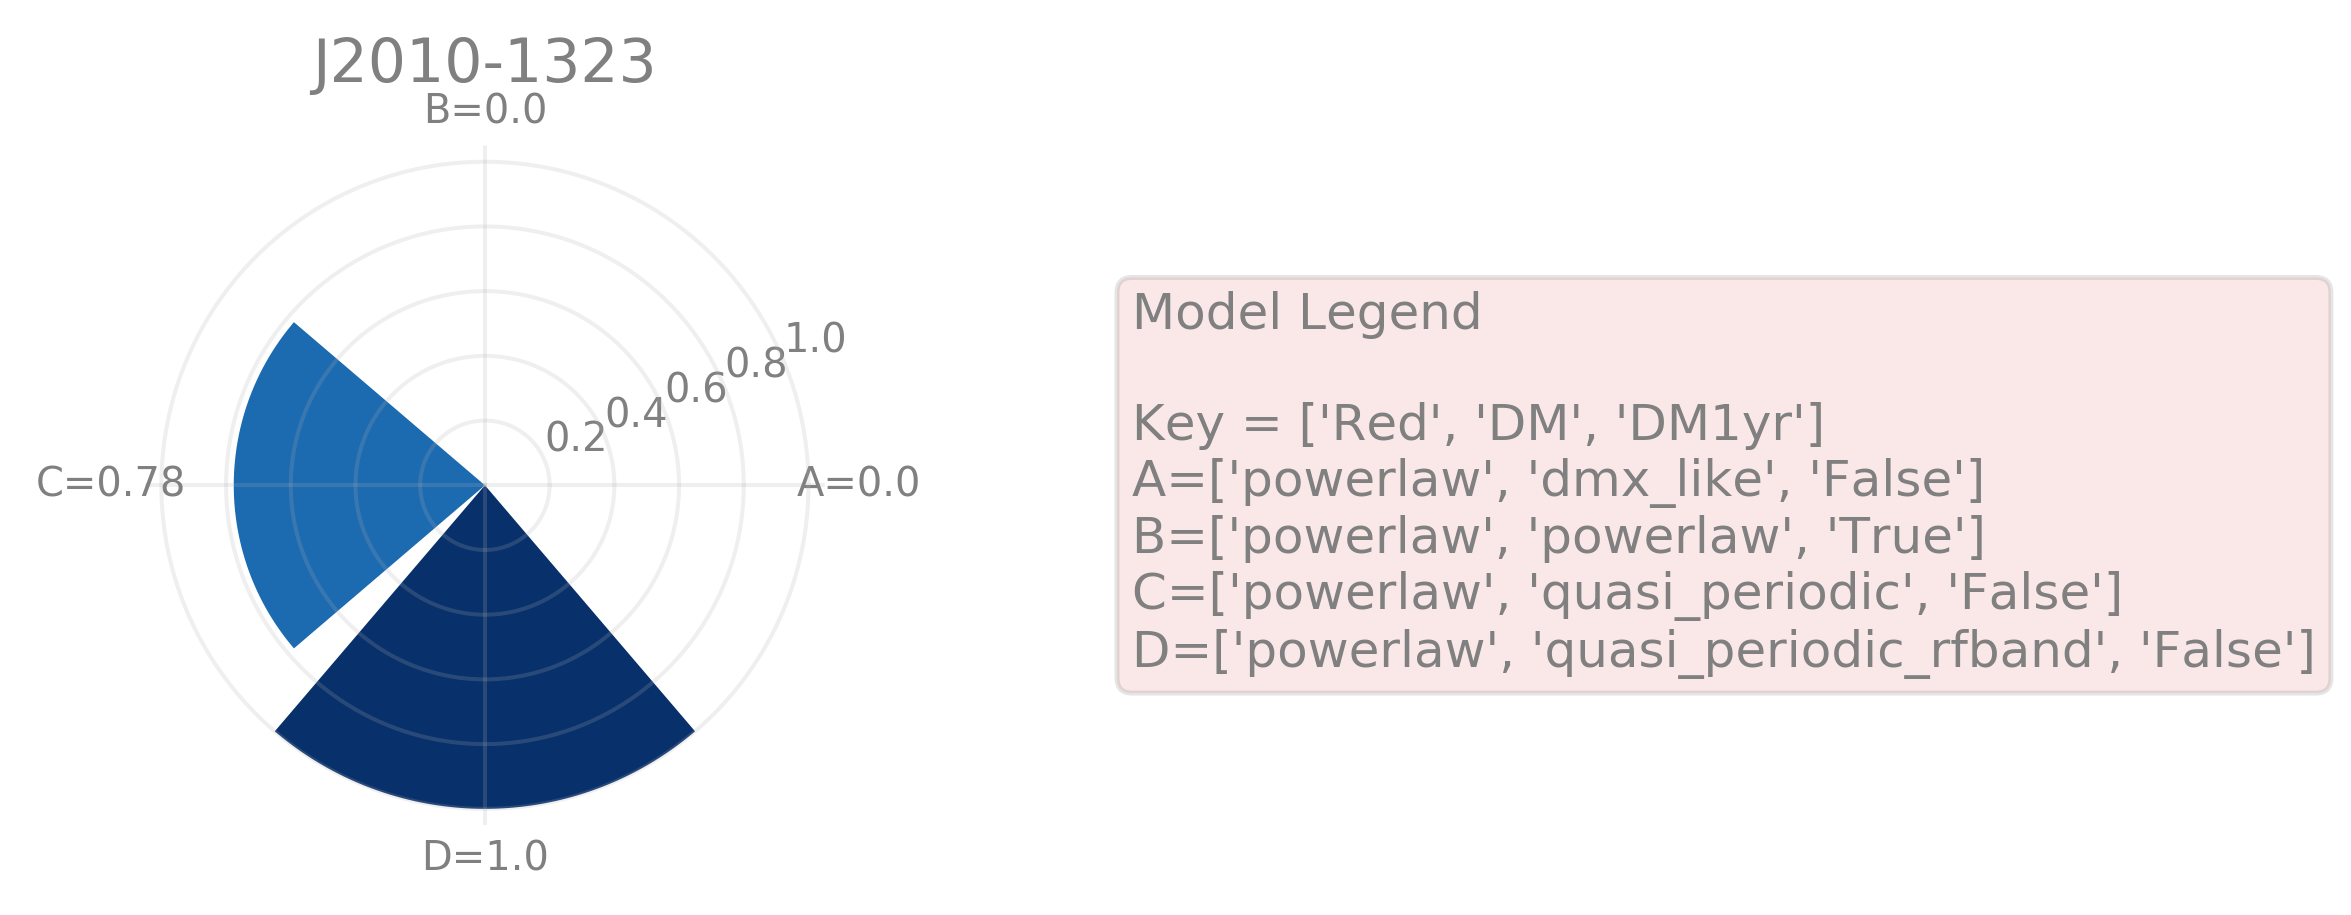

In [21]:
noise_flower(chain=chain[burn:, -5], super_model=super_model, psrname=psr.name, 
             model_dict=model_dict, key=['Red', 'DM', 'DM1yr'], norm2max=True)